# Using Wikipedia, Pandas, and Folium visualize all the Ancient Libraries and Where they were

# Packages

In [41]:
import pandas as pd
import wikipedia
import geopandas as gpd
%matplotlib inline  
import folium
import os
import regex as re
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import fuzzywuzzy.process as fwp
import matplotlib.pyplot as plt    


# Variables

In [42]:
w_page = "List of libraries in the ancient world"
col_names = ["RAW_TEXT", "NAME", "EXTRA"]
output_table = "test.csv"
countries = "ne_50m_admin_0_countries.shp"

# Read in Wiki page as variable

In [43]:
w_page = wikipedia.page(w_page)
text = w_page.content

# Save as text and read back in

In [44]:
open('temp.txt', 'a').close()
with open('temp.txt', "w", encoding="utf-8") as f:
    f.write(text)

# Read text into pandas and split text up

In [45]:
df = pd.read_csv('temp.txt', sep = '==',  header = None, skiprows =1)
df.columns = col_names
df

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,RAW_TEXT,NAME,EXTRA
0,NaN,Algeria,NaN
1,Timgad (250 A.D.) (modern Algeria)The library ...,None,NaN
2,NaN,Anatolia,NaN
3,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,None,NaN
4,Royal Library of Antioch (221 B.C. - 363 A.D.)...,None,NaN
5,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,None,NaN
6,Library of Celsus (135 A.D. - 262) (located wi...,None,NaN
7,The Imperial Library of Constantinople (337â€...,None,NaN
8,NaN,China,NaN
9,Han Imperial Library. Catalogue preserved in t...,None,NaN


# Fill NAME column populating the country for each library

In [46]:
##Fill NAME column with country assoicated with the library
df.iloc[:, 1] = df.iloc[:, 1].fillna(method='ffill')
##Remove rows not needed by using null
df2 = df[pd.notnull(df.iloc[:, 0])]
##Remove rows that are not libraries but additional resources from the intellipedia page
df2 = df2[~df2.NAME.str.contains('External links|See also|References')]
##Clean up libraries
df2 = df2 = df2[~df2.RAW_TEXT.str.contains('Qin reign|Tang dynasty|The great seats of learning')]

# Initial Cleanup

In [47]:
##Strip extra characters and fix one country issue
df2.iloc[:, 1] = df2.iloc[:, 1].str.replace('=','')
df2.iloc[:, 1] = df2.iloc[:, 1].str.replace(' ','')
df2.iloc[:, 1] = df2.iloc[:, 1].str.replace('Anatolia','Turkey')

In [48]:
##Split by first parentheses, allowing to split off date and location and remaining text from library name. 
split1 = df2['RAW_TEXT'].str.split('(', n = 1, expand = True)
##Add second column of split back to df. This will have location, date, and remaining text.
df2['Temp'] = split1[1]
##Split by ending parenthesis. This is will split what will be the date column from the location and additional text.
split2 = df2['Temp'].str.split(')', n = 1, expand = True)
##Make date column and put first column of split into date column. 
df2['Date'] = split2[0]
##Place remainder of text in temp column to split again. 
df2['Temp2'] = split2[1]
##split again splitting the second set of parenthesis this will split the date and location from remaining text
split3 = df2['Temp2'].str.split('(', n = 1, expand = True)
split4 = split3[1].str.split(')', n = 1, expand = True)
##Create location column from split4 variable and then put remaining text in Extra.  
df2['Loc'] = split4[0]
df2['Extra'] = split4[1]
##using split cleanup library data and create library column
split1 = split1[0].str.split(',', n = 1, expand = True)
split1 = split1[0].str.split('.', n = 1, expand = True)
df2['Library'] = split1[0]
##remove temp columns
df2 = df2.drop(['Temp', 'Temp2'], axis=1)
df2

,RAW_TEXT,NAME,EXTRA,Date,Loc,Extra,Library
1,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,NaN,250 A.D.,modern Algeria,The library was a gift to the Roman people and...,Timgad
3,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,NaN,1900 B.C. - 1190 B.C.,modern Bogazkoy,This archive constituted the largest collectio...,Hattusa
4,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,NaN,221 B.C. - 363 A.D.,Modern Antakya,The library was commissioned in the third cent...,Royal Library of Antioch
5,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,NaN,197 B.C. - 159 B.C.,modern Bergama,The Attalid kings formed the second best Helle...,Library of Pergamum
6,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,NaN,135 A.D. - 262,located within the city of Ephesus,This library was part of the triumvirate of li...,Library of Celsus
7,The Imperial Library of Constantinople (337â€...,Turkey,NaN,337â€“361 A.D. â€“ 29 May 1453,"Constantinople, modern Istanbul",The library was established by Constantius II ...,The Imperial Library of Constantinople
9,Han Imperial Library. Catalogue preserved in t...,China,NaN,None,None,None,Han Imperial Library
13,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,NaN,c. 295 BC,None,None,The Royal Library of Alexandria
14,"Serapeum of Alexandria, offshoot collection of...",Egypt,NaN,None,None,None,Serapeum of Alexandria
15,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,NaN,237â€“57 B.C.,None,None,Temple of Edfu Archive/Library


# Add links to table

In [49]:
##create list of library names
libs = list(df2['Library'])
##search Wikipedia for links to library names.  If found put into a list.
a = []
for w in libs: 
    try:
        page = wikipedia.page(w)
        a.append(page.url)
    except:
        pass # doing nothing on exception
##Turn links of list into dataframe and rename links.
df_tmp = pd.DataFrame(a)
df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: "Links" })
##remove everything before wiki/. This will allow us to a fuzzy join easier.
df_tmp['tmp']= df_tmp['Links'].replace('https://en.wikipedia.org/wiki/', '', regex=True)
#replace underscores with spaces
df_tmp['tmp']= df_tmp['tmp'].replace('_', ' ', regex=True)


C:\Users\fcmun\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\fcmun\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [50]:
##turn column into a list and run fuzzy wuzzy.  It will provdie best matches at 90%
choices = list(df_tmp.tmp)
def fmatch(row): 
    minscore=90 #or whatever score works for you
    choice,score = fwp.extractOne(row.Library,choices)
    return choice if score > minscore else None
##apply fmatch scoresto df2
df2['test'] = df2.apply(fmatch, axis=1)
##merge by test column used to obtain score with dataframe with actual links.
df3= pd.merge(df2, 
                  df_tmp,
                  left_on='test',
                  right_on='tmp',
                  how = 'left') 
##replace nan with None
df3['Links']= df3['Links'].replace(np.nan, 'None', regex=True)
df3

,RAW_TEXT,NAME,EXTRA,Date,Loc,Extra,Library,test,Links,tmp
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,NaN,250 A.D.,modern Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,NaN,1900 B.C. - 1190 B.C.,modern Bogazkoy,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,NaN,221 B.C. - 363 A.D.,Modern Antakya,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,NaN,197 B.C. - 159 B.C.,modern Bergama,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,NaN,135 A.D. - 262,located within the city of Ephesus,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus
5,The Imperial Library of Constantinople (337â€...,Turkey,NaN,337â€“361 A.D. â€“ 29 May 1453,"Constantinople, modern Istanbul",The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople
6,Han Imperial Library. Catalogue preserved in t...,China,NaN,None,None,None,Han Imperial Library,None,None,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,NaN,c. 295 BC,None,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,NaN,None,None,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,NaN,237â€“57 B.C.,None,None,Temple of Edfu Archive/Library,None,None,NaN


# Work to put dates and locations in correct columns. 

In [51]:
#Dates are actually located in both date and loc column.  Need to put all the dates in the date column
##if string contains date terms but into Date_F.
df3['Date_F'] = np.where(df3['Date'].str.contains('A.D.|B.C.|cent|Cent'), df3['Date'], 0)
##if string n loc column contains date terms put in a temp date column
df3['Date_Temp'] = np.where(df3['Loc'].str.contains('A.D.|B.C.|cent|Cent'), df3['Loc'], 0)
##If Date_F is 0 then move dates from Date_temp colum into Date_F
df3.loc[df3["Date_F"]==0,'Date_F'] = df3['Date_Temp']
##Remove Temp Date column
df3 = df3.drop(['Date_Temp'], axis=1)
df3

,RAW_TEXT,NAME,EXTRA,Date,Loc,Extra,Library,test,Links,tmp,Date_F
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,NaN,250 A.D.,modern Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,250 A.D.
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,NaN,1900 B.C. - 1190 B.C.,modern Bogazkoy,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C. - 1190 B.C.
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,NaN,221 B.C. - 363 A.D.,Modern Antakya,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C. - 363 A.D.
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,NaN,197 B.C. - 159 B.C.,modern Bergama,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C. - 159 B.C.
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,NaN,135 A.D. - 262,located within the city of Ephesus,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D. - 262
5,The Imperial Library of Constantinople (337â€...,Turkey,NaN,337â€“361 A.D. â€“ 29 May 1453,"Constantinople, modern Istanbul",The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337â€“361 A.D. â€“ 29 May 1453
6,Han Imperial Library. Catalogue preserved in t...,China,NaN,None,None,None,Han Imperial Library,None,None,NaN,0
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,NaN,c. 295 BC,None,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,0
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,NaN,None,None,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,0
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,NaN,237â€“57 B.C.,None,None,Temple of Edfu Archive/Library,None,None,NaN,237â€“57 B.C.


In [52]:
#Putting locations that were in both Date in Loc into Loc_F
##If loc cotains values a-z move to Loc_F
df3['Loc_F'] = np.where(df3['Loc'].str.contains(r"[a-z]"), df3['Loc'], 0)
##If values in Loc_F have cent or Cent do not keep.
df3['Loc_F'] = np.where(~df3['Loc_F'].str.contains('cent|Cent', na = False), df3['Loc_F'], 0)
##If date column has characters a-z move to Loc_Temp
df3['Loc_Temp'] = np.where(df3['Date'].str.contains(r"[a-z]"), df3['Date'], 0)
##If loc_temp does not have numbers or cent or CENT keep.
df3['Loc_Temp'] = np.where(~df3['Loc_Temp'].str.contains(r"[0-9]|Cent|cent", na = False), df3['Loc_Temp'], 0)
##if Loc_F is 0 then  populate with Loc_Temp
df3.loc[df3["Loc_F"]==0,'Loc_F'] = df3['Loc_Temp']
##Remove temp, date, and loc
df3 = df3.drop(['Loc_Temp', 'Date', 'Loc'], axis=1)

# Focus on creating start and end dates

In [53]:
##Start Date
##By performing various np.where funtions createnew column for start date
split_date = df3['Date_F'].str.split('-|â€“|to', n = 2, expand = True)
split_date[3] = np.where(split_date[1].str.contains('B.C.|BC', na=False), " B.C.", '')
split_date[4] = np.where(~split_date[0].str.contains('B.C.|A.D.|Cent|Cent', na=False), split_date[0] + split_date[3], split_date[0])
split_date[5] = np.where(split_date[1].str.contains('A.D.', na=False), " A.D.", '')
split_date[4] = np.where(~split_date[4].str.contains('B.C.|A.D.|Cent|Cent', na=False), split_date[0] + split_date[5], split_date[4])
split_date[5] = np.where(split_date[1].str.contains('A.D.', na=False), " A.D.", '')
split_date[4] = np.where(~split_date[4].str.contains('B.C.|A.D.|Cent|Cent', na=False), split_date[0] + split_date[5], split_date[4])
##Cheat - somethings I couldn't get to go in the start date. 
split_date[4].replace({'8th century': '8 A.D.'},inplace =True)
split_date[4].replace({'third century BCE': '3 B.C.'},inplace =True)
split_date[4].replace({'12th Century': '12 A.D.'},inplace =True)
split_date[4].replace({'9th': '9 A.D.'},inplace =True)
##y performing various np.where funtions create new column for End Date
split_date[6] = np.where(split_date[0].str.contains('A.D.', na=False), " A.D.", '')
split_date[7] = np.where(~split_date[1].str.contains('B.C.|A.D.|Cent|Cent|None', na=False), split_date[1] + split_date[6], split_date[1])
##Cheat -somethings I couldn't get to go in the end date. 
split_date[7].replace({'10th century': '10 A.D.'},inplace =True)
split_date[7].replace({'13th centuries': '13 A.D.'},inplace =True)
split_date[7].replace({' 5th century BC in modern': '5 B.C.'},inplace =True)
split_date = split_date.drop([2, 3,5,6], axis=1)

In [54]:
##Adding dates back in and removing not needed columns
df3['Start_Date'] = split_date[4]
df3['End_Date'] = split_date[7]
df3 = df3.drop(['EXTRA', 'Date_F'], axis=1)



In [55]:
##create numeric start date using np.where and replace
df3['Start_Date_Y']  = np.where(df3['Start_Date'].str.contains('B.C.'), df3['Start_Date'], 0)
df3['Start_Date_Y'] = df3['Start_Date_Y'].str.replace('B.C.|th','')
df3['Start_Date_Y'] = ('-' + df3['Start_Date_Y'])
df3["Start_Date_Y"] = df3["Start_Date_Y"].fillna(0)
df3.loc[df3["Start_Date_Y"]== 0 ,"Start_Date_Y"] = df3['Start_Date']
df3['Start_Date_Y'] = df3['Start_Date_Y'].str.replace('A.D.','')
df3['Start_Date']= df3['Start_Date'].replace(np.nan, 'Unknown', regex=True)
df3

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Loc_F,Start_Date,End_Date,Start_Date_Y
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,modern Algeria,250 A.D.,NaN,250
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,modern Bogazkoy,1900 B.C.,1190 B.C.,-1900
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,Modern Antakya,221 B.C.,363 A.D.,-221
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,modern Bergama,197 B.C.,159 B.C.,-197
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,located within the city of Ephesus,135 A.D.,262 A.D.,135
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,"Constantinople, modern Istanbul",337 A.D.,361 A.D.,337
6,Han Imperial Library. Catalogue preserved in t...,China,None,Han Imperial Library,None,None,NaN,0,Unknown,NaN,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,0,Unknown,NaN,NaN
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,0,Unknown,NaN,NaN
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,None,Temple of Edfu Archive/Library,None,None,NaN,0,237 B.C.,57 B.C.,-237


In [56]:
##create numeric end date using np.where and replace
df3['End_Date_Y']  = np.where(df3['End_Date'].str.contains('B.C.'), df3['End_Date'], 0)
df3['End_Date_Y'] = df3['End_Date_Y'].str.replace('B.C.|th','')
df3['End_Date_Y'] = ('-' + df3['End_Date_Y'])
df3["End_Date_Y"] = df3["End_Date_Y"].fillna(0)
df3.loc[df3["End_Date_Y"]== 0 ,"End_Date_Y"] = df3['End_Date']
df3['End_Date_Y'] = df3['End_Date_Y'].str.replace('A.D.','')
df3['End_Date']= df3['End_Date'].replace(np.nan, 'Unknown', regex=True)
df3

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Loc_F,Start_Date,End_Date,Start_Date_Y,End_Date_Y
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,modern Algeria,250 A.D.,Unknown,250,NaN
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,modern Bogazkoy,1900 B.C.,1190 B.C.,-1900,- 1190
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,Modern Antakya,221 B.C.,363 A.D.,-221,363
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,modern Bergama,197 B.C.,159 B.C.,-197,- 159
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,located within the city of Ephesus,135 A.D.,262 A.D.,135,262
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,"Constantinople, modern Istanbul",337 A.D.,361 A.D.,337,361
6,Han Imperial Library. Catalogue preserved in t...,China,None,Han Imperial Library,None,None,NaN,0,Unknown,Unknown,NaN,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,0,Unknown,Unknown,NaN,NaN
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,0,Unknown,Unknown,NaN,NaN
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,None,Temple of Edfu Archive/Library,None,None,NaN,0,237 B.C.,57 B.C.,-237,-57


# Cleaning up location column

In [57]:
##Removing modern terms
df3['Location'] = df3['Loc_F'].str.lstrip('Modern |modern |ar modern')
##Cheats
df3['Location'].replace({'located within the city of Ephesus': 'Ephesus'},inplace =True)
df3['Location'].replace({'Constantinople, modern Istanbul': 'Istanbul'},inplace =True)
df3['Location'].replace({'sul, Iraq': 'Sul'},inplace =True)
df3['Location'].replace({'Northeast Syria': None},inplace =True)
df3['Location'].replace({'Algeria': None},inplace =True)
df3 = df3.drop(['Loc_F'], axis=1)
df3['Loc_Geo'] = df3['Location'] + ', ' + df3['NAME']
df3

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Start_Date_Y,End_Date_Y,Location,Loc_Geo
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,250 A.D.,Unknown,250,NaN,None,NaN
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C.,1190 B.C.,-1900,- 1190,Bogazkoy,"Bogazkoy, Turkey"
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C.,363 A.D.,-221,363,Antakya,"Antakya, Turkey"
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,-197,- 159,Bergama,"Bergama, Turkey"
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,135,262,Ephesus,"Ephesus, Turkey"
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,337,361,Istanbul,"Istanbul, Turkey"
6,Han Imperial Library. Catalogue preserved in t...,China,None,Han Imperial Library,None,None,NaN,Unknown,Unknown,NaN,NaN,NaN,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,Unknown,Unknown,NaN,NaN,NaN,NaN
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,Unknown,Unknown,NaN,NaN,NaN,NaN
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,None,Temple of Edfu Archive/Library,None,None,NaN,237 B.C.,57 B.C.,-237,-57,NaN,NaN


# Pulling coodrinates for locations

In [58]:
##Drop nulls
libs_cityloc =  df3.loc[df3.Loc_Geo.notnull()]
##Using geopy to extract coordinates from place name and location back to dataframe
geolocator = Nominatim()
libs_cityloc_ = libs_cityloc.filter(['Loc_Geo'], axis=1)
libs_cityloc_.drop_duplicates(subset=['Loc_Geo'], inplace=True)
libs_cityloc_
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
libs_cityloc_['location'] = libs_cityloc_['Loc_Geo'].apply(geocode)
libs_cityloc_['point'] = libs_cityloc_['location'].apply(lambda loc: tuple(loc.point) if loc else None)
libs_cityloc = pd.merge(libs_cityloc, libs_cityloc_, how='left', on= 'Loc_Geo')
libs_cityloc

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.
RateLimiter caught an error, retrying (0/2 tries). Called with (*('Antakya, Turkey',), **{}).
Traceback (most recent call last):
  File "C:\Users\fcmun\Anaconda3\lib\urllib\request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "C:\Users\fcmun\Anaconda3\lib\http\client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Start_Date_Y,End_Date_Y,Location,Loc_Geo,location,point
0,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C.,1190 B.C.,-1900,- 1190,Bogazkoy,"Bogazkoy, Turkey","(Boğazköy, Nevşehir merkez, Nevşehir, İç Anado...","(38.5472734, 34.6360644, 0.0)"
1,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C.,363 A.D.,-221,363,Antakya,"Antakya, Turkey","(Antakya, Antakya (merkez), Hatay, Akdeniz Böl...","(36.2176872, 36.1653617, 0.0)"
2,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,-197,- 159,Bergama,"Bergama, Turkey","(Bergama, İzmir, Ege Bölgesi, 35700, Türkiye, ...","(39.1191544, 27.1777296, 0.0)"
3,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,135,262,Ephesus,"Ephesus, Turkey","(Efes, Arkadiane, Selçuk, İzmir, Ege Bölgesi, ...","(37.94044555, 27.3393194464968, 0.0)"
4,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,337,361,Istanbul,"Istanbul, Turkey","(İstanbul, Fatih, İstanbul, Marmara Bölgesi, 3...","(41.0096334, 28.9651646, 0.0)"
5,The Library of Aristotle (Athens) (384â€“321 B...,Greece,The Library of Aristotle was a private library...,The Library of Aristotle,None,None,NaN,384 B.C.,321 B.C.,-384,-321,Athens,"Athens, Greece","(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)"
6,Kos Library (Kos) (100 A.D.)The library was a ...,Greece,The library was a local public library situate...,Kos Library,None,None,NaN,100 A.D.,Unknown,100,NaN,Kos,"Kos, Greece","(Δήμος Κω, Περιφερειακή Ενότητα Κω, Περιφέρεια...","(36.7939719, 27.0850810793972, 0.0)"
7,The Library of Pantainos (Athens) (100 A.D.)De...,Greece,Dedicated to both Athena Archegetis and the Ro...,The Library of Pantainos,None,None,NaN,100 A.D.,Unknown,100,NaN,Athens,"Athens, Greece","(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)"
8,The Library of Rhodes (Rhodes) (100 A.D.)The l...,Greece,The library on the island of Rhodes was a dist...,The Library of Rhodes,None,None,NaN,100 A.D.,Unknown,100,NaN,Rhodes,"Rhodes, Greece","(Ρόδος, Δήμος Ρόδου, Περιφερειακή Ενότητα Ρόδο...","(36.4379874, 28.2233083, 0.0)"
9,The Library of Ashurbanipal (established 668â€...,Iraq,Long considered to be the first systematically...,The Library of Ashurbanipal,Library of Ashurbanipal,https://en.wikipedia.org/wiki/Library_of_Ashur...,Library of Ashurbanipal,Unknown,Unknown,NaN,NaN,Sul,"Sul, Iraq","(قلالش سول, مخمور, هەولێر, هەرێمی کوردستان, ال...","(35.718958, 43.672395, 0.0)"


In [59]:
#Locations are stored as tuples, split it up and create lat/lon column
libs_cityloc =  libs_cityloc.loc[libs_cityloc.point.notnull()]
tmp = pd.DataFrame(libs_cityloc['point'].tolist(), index=libs_cityloc.index)   
libs_cityloc['Lat']=tmp[0]
libs_cityloc['Lon']=tmp[1]
##create information to show when creating markers in folium  map
libs_cityloc['Info'] = libs_cityloc['Library'] + ', Creation Date: ' + libs_cityloc['Start_Date'] + ', Wiki link: ' + libs_cityloc['Links']
libs_cityloc2 = libs_cityloc.filter(['Library','Lat', 'Lon'])
libs_cityloc
##df3 = pd.merge(df3, libs_cityloc2, how = 'left', on = 'Library')
##df3

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Start_Date_Y,End_Date_Y,Location,Loc_Geo,location,point,Lat,Lon,Info
0,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C.,1190 B.C.,-1900,- 1190,Bogazkoy,"Bogazkoy, Turkey","(Boğazköy, Nevşehir merkez, Nevşehir, İç Anado...","(38.5472734, 34.6360644, 0.0)",38.547273,34.636064,"Hattusa , Creation Date: 1900 B.C. , Wiki link..."
1,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C.,363 A.D.,-221,363,Antakya,"Antakya, Turkey","(Antakya, Antakya (merkez), Hatay, Akdeniz Böl...","(36.2176872, 36.1653617, 0.0)",36.217687,36.165362,"Royal Library of Antioch , Creation Date: 221 ..."
2,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,-197,- 159,Bergama,"Bergama, Turkey","(Bergama, İzmir, Ege Bölgesi, 35700, Türkiye, ...","(39.1191544, 27.1777296, 0.0)",39.119154,27.177730,"Library of Pergamum , Creation Date: 197 B.C. ..."
3,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,135,262,Ephesus,"Ephesus, Turkey","(Efes, Arkadiane, Selçuk, İzmir, Ege Bölgesi, ...","(37.94044555, 27.3393194464968, 0.0)",37.940446,27.339319,"Library of Celsus , Creation Date: 135 A.D. , ..."
4,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,337,361,Istanbul,"Istanbul, Turkey","(İstanbul, Fatih, İstanbul, Marmara Bölgesi, 3...","(41.0096334, 28.9651646, 0.0)",41.009633,28.965165,"The Imperial Library of Constantinople , Crea..."
5,The Library of Aristotle (Athens) (384â€“321 B...,Greece,The Library of Aristotle was a private library...,The Library of Aristotle,None,None,NaN,384 B.C.,321 B.C.,-384,-321,Athens,"Athens, Greece","(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)",37.984149,23.727984,"The Library of Aristotle , Creation Date: 384 ..."
6,Kos Library (Kos) (100 A.D.)The library was a ...,Greece,The library was a local public library situate...,Kos Library,None,None,NaN,100 A.D.,Unknown,100,NaN,Kos,"Kos, Greece","(Δήμος Κω, Περιφερειακή Ενότητα Κω, Περιφέρεια...","(36.7939719, 27.0850810793972, 0.0)",36.793972,27.085081,"Kos Library , Creation Date: 100 A.D., Wiki li..."
7,The Library of Pantainos (Athens) (100 A.D.)De...,Greece,Dedicated to both Athena Archegetis and the Ro...,The Library of Pantainos,None,None,NaN,100 A.D.,Unknown,100,NaN,Athens,"Athens, Greece","(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)",37.984149,23.727984,"The Library of Pantainos , Creation Date: 100 ..."
8,The Library of Rhodes (Rhodes) (100 A.D.)The l...,Greece,The library on the island of Rhodes was a dist...,The Library of Rhodes,None,None,NaN,100 A.D.,Unknown,100,NaN,Rhodes,"Rhodes, Greece","(Ρόδος, Δήμος Ρόδου, Περιφερειακή Ενότητα Ρόδο...","(36.4379874, 28.2233083, 0.0)",36.437987,28.223308,"The Library of Rhodes , Creation Date: 100 A.D..."
9,The Library of Ashurbanipal (established 668â€...,Iraq,Long considered to be the first systematically...,The Library of Ashurbanipal,Library of Ashurbanipal,https://en.wikipedia.org/wiki/Library_of_Ashur...,Library of Ashurbanipal,Unknown,Unknown,NaN,NaN,Sul,"Sul, Iraq","(قلالش سول, مخمور, هەولێر, هەرێمی کوردستان, 

# Creating map that shows where Ancient Libraries were located (City Level)

In [60]:
##Make folium map
mkr = folium.Map(location=[35.283731, 35.203442], tiles='stamenterrain', zoom_start=5)
libs_cityloc.apply(lambda row:folium.Marker(location=[row["Lat"], row["Lon"]], popup=row['Info'],).add_to(mkr),axis=1)
mkr.save(outfile= "Library_Locations.html")
mkr

# Create Chloropleth using Folium package. Save off as HTML file.  

In [61]:
#Group data to create counts of libraries within each country
groups = df2.groupby('NAME', as_index=False).count()
groups1 = groups.drop(['RAW_TEXT'], axis=1)

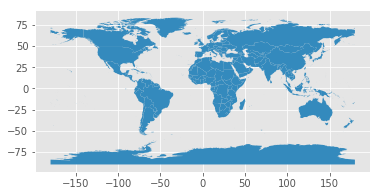

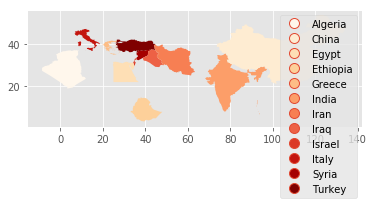

In [62]:
#Read in country shapefile and merge with groups to only keep countries that have ancient libraries.  Save the that geodataframe off as json file
geo_data = gpd.read_file(countries, encoding="utf-8")
country_shapes = geo_data.merge(groups, on='NAME', how='right')
geo_data.plot()
country_shapes.plot('NAME', cmap='OrRd', legend = True)
country_shapes = country_shapes[['NAME', 'geometry']]
country_shapes = country_shapes[pd.notnull(country_shapes['geometry'])]
country_shapes
country_shapes.to_file('country.json', driver='GeoJSON')

In [63]:
##create cholorepleth showing counts of ancient libraries in each country. I will use the country json file and groupby dataframe
country_geo = os.path.join('country.json')
m = folium.Map(location=[30.3755321, 69.345116], tiles='stamenterrain', zoom_start=3)
m.choropleth(
 geo_data=country_geo,
 name='choropleth',
 data=groups,
 columns=['NAME', 'Library'],
 key_on='feature.properties.NAME',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.0,
 legend_name='Libraries'
)
folium.LayerControl().add_to(m)
m.save(outfile= "Countries_LibraryCNT.html")
os.remove("country.json")
os.remove("temp.txt")
m

C:\Users\fcmun\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# Date analysis on how many years since these ancient libraries were created

In [64]:
#Get number of years since library was created.  Subtract library start date from current date.  -1 because there is no year zero.
date_compare = df3.filter(['Library', 'Start_Date', 'Start_Date_Y'], axis=1)
date_compare['current_date'] = 2018
date_compare = date_compare.dropna(subset=['Start_Date_Y'])
date_compare['Start_Date_Y'] = pd.to_numeric(date_compare['Start_Date_Y'], errors='coerce')
date_compare['current_date'] = pd.to_numeric(date_compare['current_date'], errors='coerce')
date_compare['Years'] = np.where(date_compare['Start_Date'].str.contains('A.D.', na=False), date_compare['current_date'] - date_compare['Start_Date_Y'], '')
date_compare.loc[date_compare["Start_Date"].str.contains('B.C.',), 'Years'] = date_compare['current_date'] - date_compare['Start_Date_Y'] -1
date_compare

,Library,Start_Date,Start_Date_Y,current_date,Years
0,Timgad,250 A.D.,250,2018,1768
1,Hattusa,1900 B.C.,-1900,2018,3917
2,Royal Library of Antioch,221 B.C.,-221,2018,2238
3,Library of Pergamum,197 B.C.,-197,2018,2214
4,Library of Celsus,135 A.D.,135,2018,1883
5,The Imperial Library of Constantinople,337 A.D.,337,2018,1681
9,Temple of Edfu Archive/Library,237 B.C.,-237,2018,2254
11,The Library of Aristotle,384 B.C.,-384,2018,2401
12,Kos Library,100 A.D.,100,2018,1918
13,The Library of Pantainos,100 A.D.,100,2018,1918


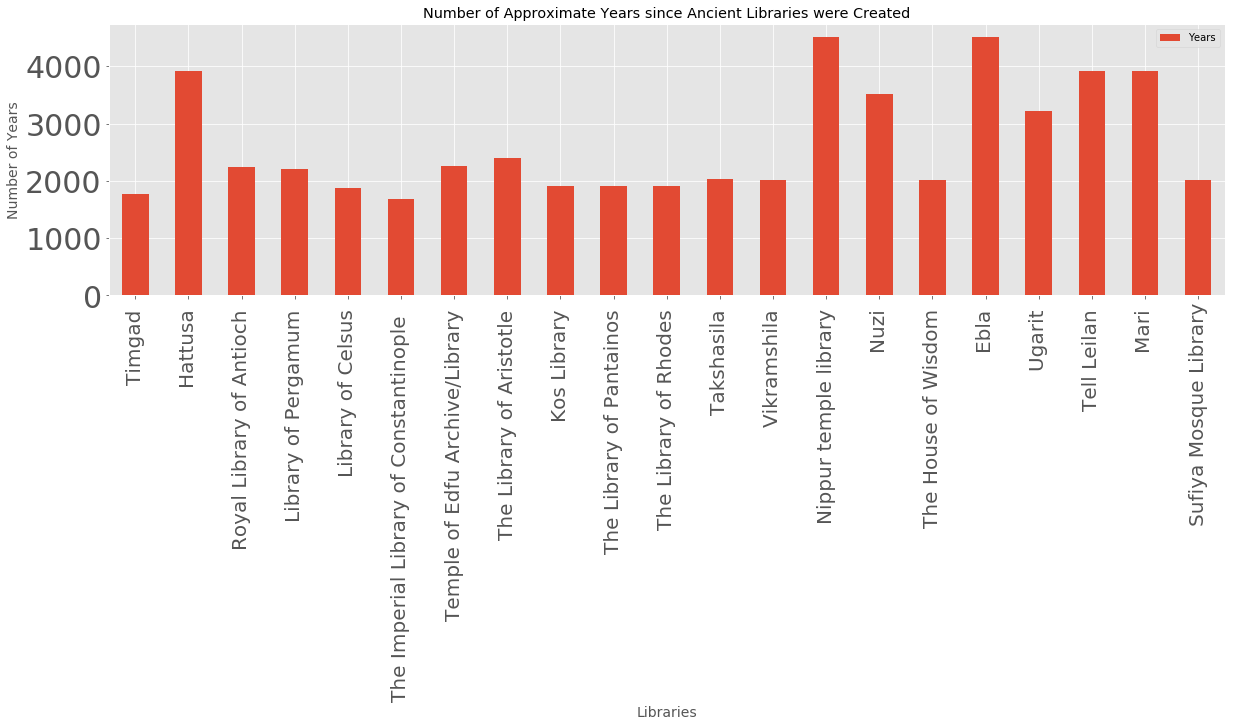

In [65]:
##Create a bar graph showing number of years by library
plt.style.use('ggplot')
date_compare2 = date_compare.filter(['Library', 'Years'], axis=1)
date_compare2['Years'] = pd.to_numeric(date_compare2['Years'], errors='coerce')
ax = date_compare2.plot(kind='bar', title ="Number of Approximate Years since Ancient Libraries were Created"
                        ,figsize=(20, 5), legend=True, fontsize = 30)
ax.set_xlabel("Libraries",fontsize=14)
ax.set_ylabel("Number of Years",fontsize=14)
ax.set_xticklabels(date_compare2['Library'], fontsize = 20, rotation=90)
plt.savefig('Number_since_Creation.png')
plt.show()

# Date Analysis on number of years library existed (Only for libraries with start and end dates)

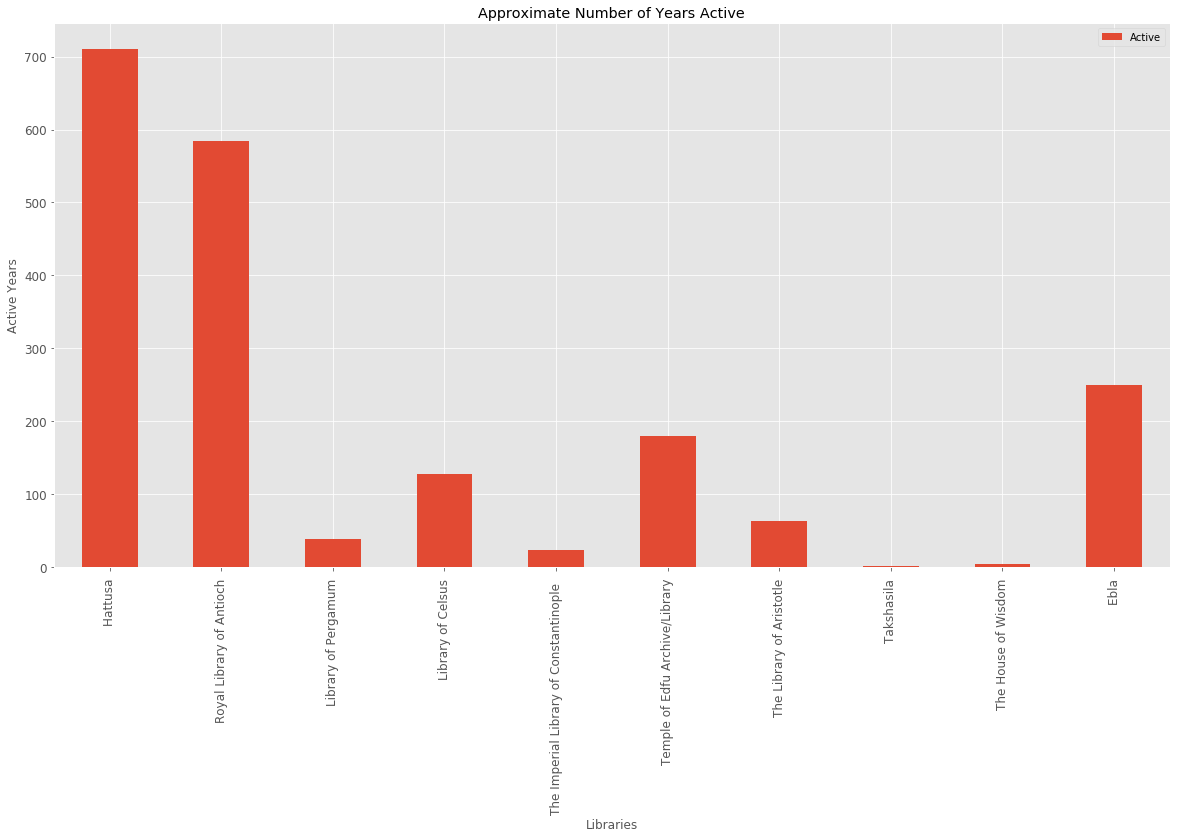

In [66]:
##Create bar graph showing number of years library existed. 
plt.style.use('ggplot')
date_compare3 = df3.filter(['Library', 'Start_Date', 'End_Date', 'Start_Date_Y', 'End_Date_Y'], axis=1)
##date_compare3= date_compare3.dropna(subset=['Start_Date_Y', 'End_Date_Y'], how='all')
date_compare3 = date_compare3.dropna(subset=['Start_Date_Y'])
date_compare3 = date_compare3.dropna(subset=['End_Date_Y'])
date_compare3['Start_Date_Y'] = pd.to_numeric(date_compare3['Start_Date_Y'], errors='coerce')
date_compare3['End_Date_Y'] = date_compare3['End_Date_Y'].str.replace(' ', '')
date_compare3['End_Date_Y'] = pd.to_numeric(date_compare3['End_Date_Y'], errors='coerce')
date_compare3['Active'] = date_compare3['End_Date_Y'] - date_compare3['Start_Date_Y']
date_compare3 = date_compare3.filter(['Library', 'Active', 'Start_Date'])
ax = date_compare3.plot(kind='bar', stacked = 'True', title ="Approximate Number of Years Active"
                        ,figsize=(20, 10),legend=True, fontsize=12)
ax.set_xlabel("Libraries",fontsize=12)
ax.set_ylabel("Active Years",fontsize=12)
ax.set_xticklabels(date_compare3['Library'], rotation=90)
plt.savefig('Years_Active')
plt.show()



# Tablets, Manuscripts, and Scrolls

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


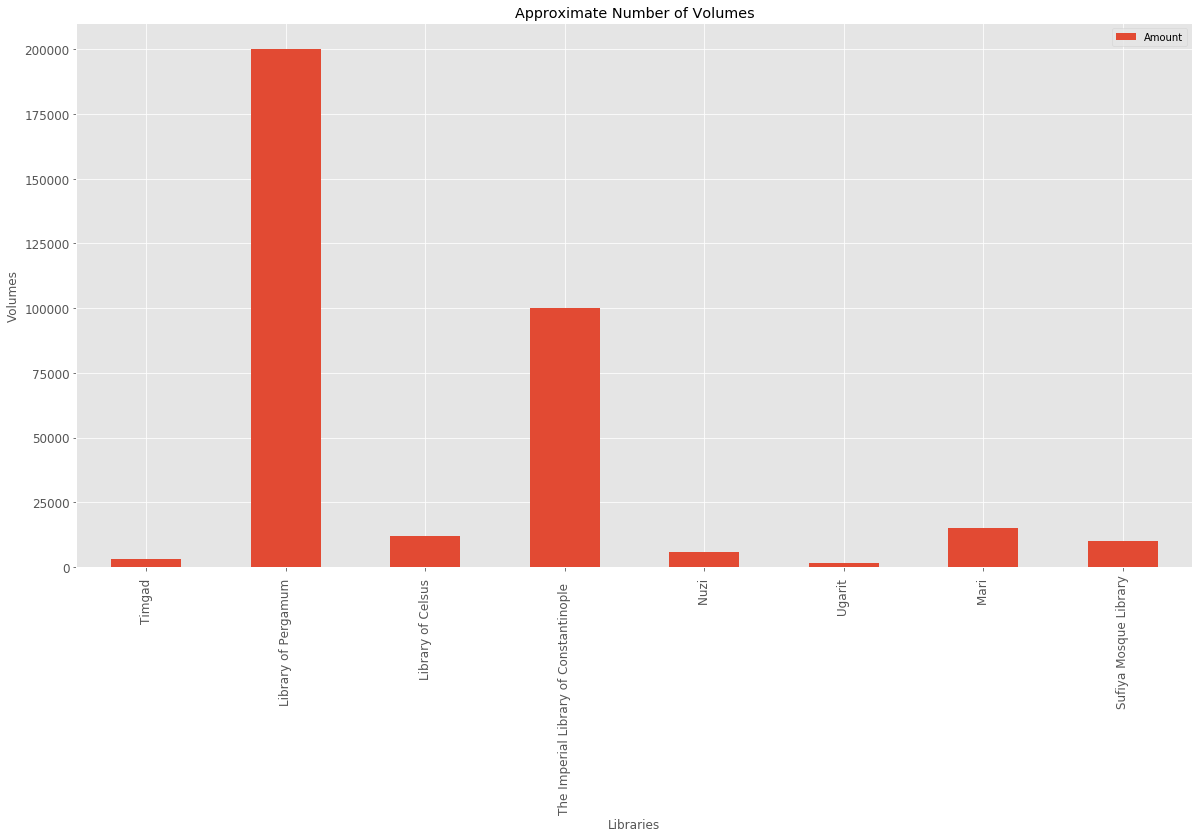

In [67]:
##using extract and replace.  Create two columns one containing the types of works called Types and the other containing the amounts called Amounts. 
df3['Archives'] = df3['Extra']
df3['Type'] = df3.Archives.str.extract('(volumes|texts|archives|tablets|scrolls)', expand=True)
df3['Archives'] = df3['Extra'].str.replace(',','')
df3['Amount'] = df3['Archives'].str.extract('(\d+)', expand=False)
df3['Amount'] = df3['Amount'].str.replace('19','')
Archives = df3.dropna(subset=['Type'])
Archives['Amount'] = pd.to_numeric(Archives['Amount'], errors='coerce')
Archives['Start_Date_Y'] = pd.to_numeric(Archives['Start_Date_Y'], errors='coerce')
Archives = Archives.dropna(subset=['Amount'])
Archives2 = Archives.filter(['Library', 'Type', 'Amount'])
Archives2
ax = Archives2.plot(kind='bar',title ="Approximate Number of Volumes"
                        ,figsize=(20, 10),legend=True, fontsize=12)
ax.set_xlabel("Libraries",fontsize=12)
ax.set_ylabel("Volumes",fontsize=12)
ax.set_xticklabels(Archives2['Library'], rotation=90)
plt.savefig('Volumes')
plt.show()


In [68]:
Archives

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Start_Date_Y,End_Date_Y,Location,Loc_Geo,Archives,Type,Amount
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,250 A.D.,Unknown,250.0,NaN,None,NaN,The library was a gift to the Roman people and...,scrolls,3000.0
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,-197.0,- 159,Bergama,"Bergama, Turkey",The Attalid kings formed the second best Helle...,volumes,200000.0
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,135.0,262,Ephesus,"Ephesus, Turkey",This library was part of the triumvirate of li...,volumes,12000.0
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,337.0,361,Istanbul,"Istanbul, Turkey",The library was established by Constantius II ...,volumes,100000.0
22,Nuzi (Modern Yorgan Tepe) (1500 B.C.)This arch...,Iraq,"This archive consisted of over 6,000 tablets w...",Nuzi,Nuzi,https://en.wikipedia.org/wiki/Nuzi,Nuzi,1500 B.C.,Unknown,-1500.0,NaN,Yorgan Tepe,"Yorgan Tepe, Iraq",This archive consisted of over 6000 tablets wr...,tablets,6000.0
29,Ugarit (Modern Ras Shamra) (1200 B.C.)Several ...,Syria,Several thousand texts consisting of diplomati...,Ugarit,Ugarit,https://en.wikipedia.org/wiki/Ugarit,Ugarit,1200 B.C.,Unknown,-1200.0,NaN,Ras Shamra,"Ras Shamra, Syria",Several thousand texts consisting of diplomati...,texts,1400.0
31,Mari (Modern Tell Hariri) (1900 B.C.)The archi...,Syria,"The archive held approximately 15,000 tablets ...",Mari,None,None,NaN,1900 B.C.,Unknown,-1900.0,NaN,Tell Hariri,"Tell Hariri, Syria",The archive held approximately 15000 tablets w...,tablets,15000.0
32,"Sufiya Mosque Library, Grand Umayyad Mosque (A...",Syria,"More than 10,000 volumes were housed in this l...",Sufiya Mosque Library,None,None,NaN,12 A.D.,Unknown,12.0,NaN,Aleppo,"Aleppo, Syria",More than 10000 volumes were housed in this li...,volumes,10000.0


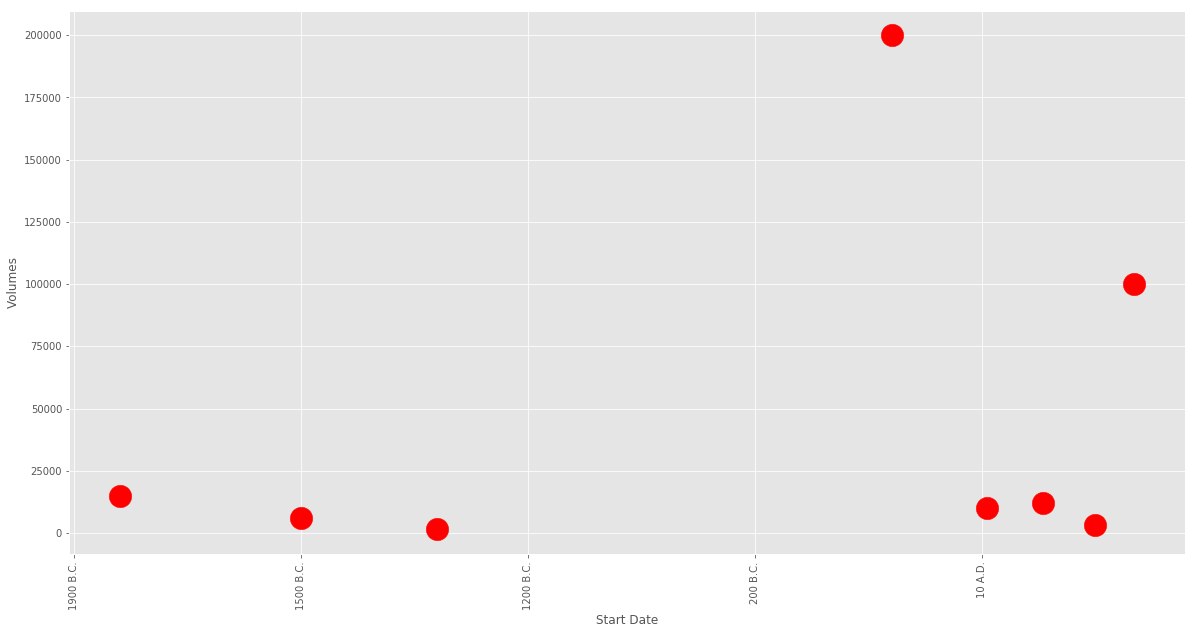

In [69]:
##Create scatter plot showing amounts of works by year.  
Archives.sort_values('Start_Date_Y')
ax = Archives.plot(kind='scatter', x= 'Start_Date_Y', y= 'Amount', s = 500, figsize=(20, 10), c = 'red')
ax.set_xlabel("Start Date",fontsize=12)
ax.set_ylabel("Volumes",fontsize=12)
##ax.get_xticklabels(Archives['Start_Date_Y'])
xlabel = ['1900 B.C.', '1900 B.C.', '1500 B.C.', '1200 B.C.', '200 B.C.', '10 A.D.', '150 A.D.', '250 A.D.', '350 A.D.']
ax.set_xticklabels(xlabel, rotation=90)
plt.show()

# Final Table Output

In [ ]:
df3.to_csv('AncientLibraries_Data_2MAR19.csv')
df3

# Extra Stuff

In [ ]:
##geo_data.to_file('country.geojson', driver='GeoJSON')
##country_geo = os.path.join('country.geojson')
##https://deparkes.co.uk/2016/06/10/folium-map-tiles/
##https://stackoverflow.com/questions/53571106/choropleth-with-folium
##https://stackoverflow.com/questions/16842001/copy-text-between-parentheses-in-pandas-dataframe-column-into-another-column
##https://stackoverflow.com/questions/22588316/pandas-applying-regex-to-replace-values
##https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
##https://stackoverflow.com/questions/15857797/bc-dates-in-python
##https://stackoverflow.com/questions/43089275/numpy-where-with-like-operator
##https://stackoverflow.com/questions/47723919/iterate-geolocation-over-pandas-dataframe
##https://automating-gis-processes.github.io/CSC18/lessons/L3/geocoding.html
##https://geopy.readthedocs.io/en/stable/#usage-with-pandas
##https://stackoverflow.com/questions/42756934/how-to-plot-lat-and-long-from-pandas-dataframe-on-folium-map-group-by-some-label
##https://stackoverflow.com/questions/35380933/how-to-merge-two-pandas-dataframes-based-on-a-similarity-function